# Network Traffic Classification and Intrusion Detection

Inspired by the book <em>Machine Learning & Security</em> by Clarence Chio & David Freeman, I use the NSL-KDD dataset (https://www.unb.ca/cic/datasets/nsl.html) to classify network attacks. I begin with a similar approach as Chio and Freeman in classifying specific network attacks using supervised learning. I revise this approach, developing an intrusion detection algorithm, using a combination of supervised and unsupervised binary classification models and strategies. I then evaluate the model and compare the 2 approaches to intrusion detection, weighing the pros and cons of each. Finally, I create an interactive dashboard prototype for a security team, incorporating explainability models, charts, rough measures of risk, and basic examples of remediation recommendations.

## Data Background
- Data Source: https://www.unb.ca/cic/datasets/nsl.html
- Feature Descriptions: https://kdd.ics.uci.edu/databases/kddcup99/task.html, https://www.aldapa.eus/res/gureKddcup/README.pdf

### Attack Categories
- dos: denial of service
- r2l: unauthorized access from remote servers
- u2r: privilege escalation attempts
- probe: brute force probing attacks

https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657

## Table of Contents
1. Setup
2. Data Exploration and Feature Selection
3. Resampling
4. Supervised Modeling
   - Selecting a classifier
       - Multi-class Classification
       - Binary Classiciation and Feature Engineering
   
5. Threshold Selection (Optimizing precision and recall)  
6. Unsupervised Modeling - Clustering
7. Combine Supervised and Unsupervised Models
8. Evaluation
9. Explainability
10. Dashboard
11. Conclusion

## 1. Setup

In [485]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, DMatrix
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy.stats import uniform
from sklearn import metrics
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from random import randint
from sklearn.feature_selection import SelectPercentile

from matplotlib import pyplot
from matplotlib.patches import Rectangle
import lime
import lime.lime_tabular
from __future__ import print_function

%matplotlib inline

In [2]:
train_file = 'nsl-kdd/KDDTrain+.txt'
test_file = 'nsl-kdd/KDDTest+.txt'

In [3]:
category = defaultdict(list)
category['benign'].append('normal')

with open('nsl-kdd/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [4]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [5]:
df_train_master = pd.read_csv(train_file, names=header_names)
df_train_master['attack_category'] = df_train_master['attack_type'] \
                                .map(lambda x: attack_mapping[x])
df_train_master.drop(['success_pred'], axis=1, inplace=True)
    
df_test = pd.read_csv(test_file, names=header_names)
df_test['attack_category'] = df_test['attack_type'] \
                                .map(lambda x: attack_mapping[x])
df_test.drop(['success_pred'], axis=1, inplace=True)

## 2. Data Exploration and Feature Selection

In [6]:
df_train_master.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,benign
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,benign
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,benign
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,benign


In [7]:
df_train = df_train_master.copy()

In [8]:
df_train['attack_category'].value_counts()

benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64

In [9]:
df_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df_train.shape

(125973, 43)

In [11]:
df_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type', 'attack_category'],
      dtype='object')

In [12]:
column_types = defaultdict(list)
with open('nsl-kdd/kddcup_names.txt', 'r') as f:
    for line in f.readlines():
        col, coltype = line.replace('.', '').strip().split(': ')
        column_types[coltype].append(col)

In [13]:
column_types.keys()

dict_keys(['continuous', 'symbolic'])

In [14]:
continuous_cols = ['duration',
              'src_bytes',
              'dst_bytes',
              'wrong_fragment',
              'urgent',
              'hot',
              'num_failed_logins',
              'num_compromised',
              'num_root',
              'num_file_creations',
              'num_shells',
              'num_access_files',
              'num_outbound_cmds',
              'count',
              'srv_count',
              'serror_rate',
              'srv_serror_rate',
              'rerror_rate',
              'srv_rerror_rate',
              'same_srv_rate',
              'diff_srv_rate',
              'srv_diff_host_rate',
              'dst_host_count',
              'dst_host_srv_count',
              'dst_host_same_srv_rate',
              'dst_host_diff_srv_rate',
              'dst_host_same_src_port_rate',
              'dst_host_srv_diff_host_rate',
              'dst_host_serror_rate',
              'dst_host_srv_serror_rate',
              'dst_host_rerror_rate',
              'dst_host_srv_rerror_rate']

binary_cols = ['root_shell',
                 'su_attempted',
                 'land',
                 'logged_in',
                 'is_host_login',
                 'is_guest_login']

nominal_cols = ['flag', 'protocol_type', 'service']

In [15]:
df_train[binary_cols].describe()

,root_shell,su_attempted,land,logged_in,is_host_login,is_guest_login
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.001342,0.001103,0.000198,0.395736,0.000008,0.009423
std,0.036603,0.045154,0.014086,0.489010,0.002817,0.096612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df_train[continuous_cols].describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.022687,0.000111,0.204409,0.001222,0.279250,0.302192,0.012669,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.253530,0.014366,2.149968,0.045239,23.942042,24.399618,0.483935,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,3.000000,3.000000,77.000000,5.000000,7479.000000,7468.000000,43.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df_train['num_outbound_cmds'].value_counts()

0    125973
Name: num_outbound_cmds, dtype: int64

'num_outbound_cmds' only has 1 value, so we are dropping from our dataframes and continuous columns list

In [18]:
df_train = df_train.drop(columns = 'num_outbound_cmds')
df_test = df_test.drop(columns = 'num_outbound_cmds')
continuous_cols.remove('num_outbound_cmds')

In [19]:
df_train['su_attempted'].value_counts()

0    125893
2        59
1        21
Name: su_attempted, dtype: int64

According to the documentation, 'su_attempted' is supposed to be a binary attribute; therefore, we are dropping the "2" values and replacing them with the default value of "0".

In [20]:
df_train['su_attempted'] = df_train['su_attempted'].replace(2,0)
df_test['su_attempted'] = df_test['su_attempted'].replace(2,0)

In [21]:
df_train['su_attempted'].value_counts()

0    125952
1        21
Name: su_attempted, dtype: int64

One-hot encoding for categorical variables and define our test data

In [22]:
df_total = pd.concat([df_train.drop(columns = ['attack_category','attack_type']), df_test.drop(columns = ['attack_category','attack_type'])])
df_total = pd.get_dummies(df_total, columns = nominal_cols, drop_first = True)

In [23]:
y = df_train['attack_category']
y_test = df_test['attack_category']

X = df_total[:len(df_train)]
X_test = df_total[-len(df_test):]

col_names = list(df_total.columns)

<AxesSubplot:>

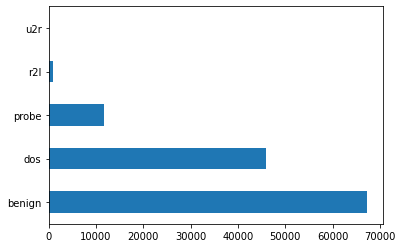

In [24]:
df_train['attack_category'].value_counts().plot(kind='barh')

## 3. Resampling

As seen above, despite malicious vs benign label distributions being fairly even, there is a very uneven distribution of the types of attacks in our training data. In order to increase the representation of some of the minority classes and decrease the representation of some of the majority classes, we take a resampling approach that combines oversampling and undersampling

In [25]:
sm = SMOTE(sampling_strategy='auto', random_state=1)
X_sm, y_sm = sm.fit_resample(X, y)
print(pd.Series(y_sm).value_counts())

probe     67343
r2l       67343
u2r       67343
dos       67343
benign    67343
Name: attack_category, dtype: int64


In [26]:
mean_len = int(pd.Series(y).value_counts().sum()/5)
ratio = {'benign': mean_len,
         'dos': mean_len,
         'probe': mean_len,
         'r2l': mean_len,
         'u2r': mean_len}

rus = RandomUnderSampler(sampling_strategy=ratio, random_state=1, replacement=True)
X_rus, y_rus = rus.fit_resample(X_sm, y_sm)
print(pd.Series(y_rus).value_counts())

u2r       25194
dos       25194
probe     25194
benign    25194
r2l       25194
Name: attack_category, dtype: int64


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


<AxesSubplot:>

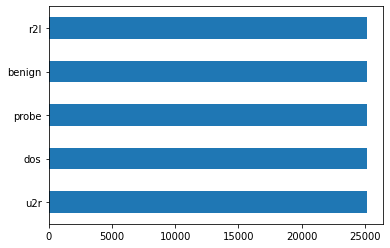

In [115]:
pd.Series(y_rus).value_counts().plot(kind='barh')

## 4. Modeling

### Selecting a classifier

### Multi-class classification

#### Cross-valudate 6 potential models

In [116]:
models = {'rf_model': RandomForestClassifier(random_state=2), \
          'lr_model': LogisticRegression(solver = 'newton-cg', random_state = 3), \
         'dt_model': DecisionTreeClassifier(random_state = 2), \
         'xgb_model': XGBClassifier(random_state = 2)}

In [117]:
preprocessor = ColumnTransformer(transformers = [
    ('scaler', StandardScaler(), continuous_cols)
], remainder = 'passthrough')

In [118]:
def get_cv_accuracy(X, y, model):
    model_pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    return list(cross_val_score(model_pipeline, X, y, cv = 3))


In [119]:
scores = []
for model in models:
    print(model)
    accuracies = get_cv_accuracy(X_rus, y_rus, models[model])
    for acc in accuracies:
        scores.append((model, acc))

rf_model
lr_model
dt_model
xgb_model


In [120]:
df_models = pd.DataFrame(scores, columns = ['Model', 'Accuracy'])

<AxesSubplot:title={'center':'3-Fold Cross-Validation'}, xlabel='Model', ylabel='Accuracy'>

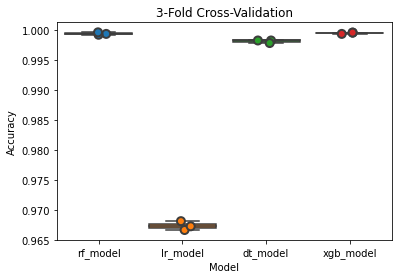

In [128]:
sns.boxplot(x = 'Model', y = 'Accuracy', data = df_models).set_title('3-Fold Cross-Validation')
sns.stripplot(x = 'Model', y = 'Accuracy', data = df_models, size = 8, jitter = True, edgecolor = 'gray', linewidth = 2)

In [122]:
xgb_multi_v1 = Pipeline([('preprocessor', preprocessor), ('model', models['xgb_model'])])

In [123]:
xgb_multi_v1.fit(X_rus, y_rus)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'num_compromised',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                               

In [124]:
multi_preds = xgb_multi_v1.predict(X_test)

In [125]:
print(classification_report(y_test, multi_preds))

              precision    recall  f1-score   support

      benign       0.70      0.97      0.81      9711
         dos       0.96      0.79      0.87      7636
       probe       0.85      0.80      0.82      2423
         r2l       0.99      0.17      0.29      2574
         u2r       0.51      0.10      0.17       200

    accuracy                           0.79     22544
   macro avg       0.80      0.57      0.59     22544
weighted avg       0.83      0.79      0.77     22544



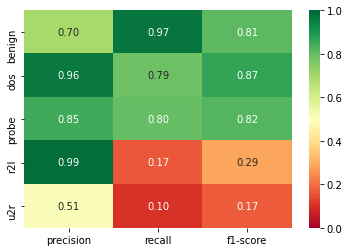

In [197]:
plot_class_report(y_test, multi_preds, support = False)

In [139]:
df_multi.iloc[:-1, :].drop(columns = ['macro avg', 'weighted avg'])

,benign,dos,probe,r2l,u2r,accuracy
precision,0.696149,0.964681,0.848246,0.986301,0.512195,0.791031
recall,0.971785,0.786930,0.798184,0.167832,0.105000,0.791031
f1-score,0.811192,0.866787,0.822454,0.286853,0.174274,0.791031


In [126]:
simple_preds = [0.0 if x == 'benign' else 1.0 for x in multi_preds]
simple_y = y_test.map(lambda x: 0.0 if x == 'benign' else 1.0)

In [127]:
print(classification_report(simple_y, simple_preds))

              precision    recall  f1-score   support

         0.0       0.70      0.97      0.81      9711
         1.0       0.97      0.68      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.80     22544
weighted avg       0.85      0.81      0.80     22544



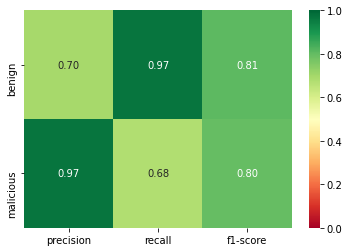

In [196]:
plot_class_report(simple_y, simple_preds, ['benign', 'malicious'], support = False)

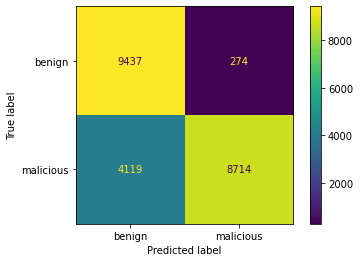

In [218]:
print_confusion(simple_y, simple_preds)

In [229]:
def plot_class_report(y_actual, y_pred, yticklabels = 'auto', support = True):
    my_dict = classification_report(y_actual, y_pred, output_dict = True)
    df_multi = pd.DataFrame(my_dict)
#     fig, ax = pyplot.subplots(figsize=(8,4))
    if support == True:
        sns.heatmap(df_multi.drop(columns = ['macro avg', 'weighted avg', 'accuracy']).T, annot = True, cmap = 'RdYlGn', yticklabels = yticklabels, vmin = 0, vmax = 1, fmt = '.2f')
        plt.show()
    else:
        sns.heatmap(df_multi.iloc[:-1, :].drop(columns = ['macro avg', 'weighted avg', 'accuracy']).T, annot = True, cmap = 'RdYlGn', yticklabels = yticklabels, vmin = 0, vmax = 1, fmt = '.2f')
        plt.show()

#### Multi-class classification of attack type does a decent job at identifying attack types; however, its recall for identifying malicious connections is too low. I decided to focus more on intrusion detection than attack classification, but still valued the results above in choosing an algorithm

### Binary Classification and Feature Engineering

In [39]:
y_rus_benign = y_rus.map(lambda x: 0.0 if x == 'benign' else 1.0)


In [40]:
models = {'rf_model': RandomForestClassifier(random_state=2), \
          'lr_model': LogisticRegression(random_state = 2), \
         'dt_model': DecisionTreeClassifier(random_state = 2), \
         'xgb_model': XGBClassifier(random_state = 2)}

In [41]:
preprocessor = ColumnTransformer(transformers = [
    ('scaler', StandardScaler(), continuous_cols)
], remainder = 'passthrough')

In [42]:
def get_cv_accuracy(X, y, model):
    model_pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    return list(cross_val_score(model_pipeline, X, y, cv = 5))


#### I decided to reduce the number of features through SelectPercentile, performing ANOVA tests and returning the F-values for the features to determine their independent relevance to the target vector. After some experimentation, I decided to keep the top 33% of features according to their F-score. I chose to measure the Area Under the Curve (AUC) for the ROC curve so I could later optimize the threshold to reduce false negatives.

In [43]:
def get_cv_roc(X, y, model):
    model_pipeline = Pipeline([('preprocessor', preprocessor), ('select', SelectPercentile(percentile = 33)), ('model', model)])
    return list(cross_val_score(model_pipeline, X, y, cv = 5, scoring = 'roc_auc'))

In [44]:
roc_scores = []
for model in models:
    print(model)
    aucs = get_cv_roc(X_rus, y_rus_benign, models[model])
    for auc in aucs:
        roc_scores.append((model, auc))

rf_model
lr_model
dt_model
xgb_model


In [45]:
df_models = pd.DataFrame(roc_scores, columns = ['Model', 'AUC'])

<AxesSubplot:title={'center':'AUC'}, xlabel='Model', ylabel='AUC'>

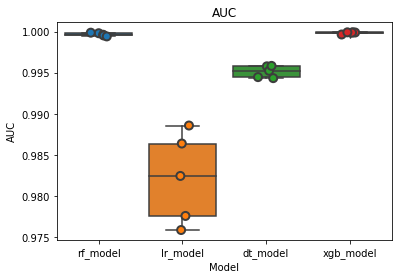

In [46]:
sns.boxplot(x = 'Model', y = 'AUC', data = df_models).set_title('AUC')
sns.stripplot(x = 'Model', y = 'AUC', data = df_models, size = 8, jitter = True, edgecolor = 'gray', linewidth = 2)

#### Ensemble forest methods tended to perform better according to the AUC measure

In [47]:
forest_models = {'rf_model': RandomForestClassifier(random_state=2), \
         'xgb_model': XGBClassifier(random_state = 2)}

In [48]:
scores = []
for model in forest_models:
    print(model)
    accuracies = get_cv_roc(X_rus, y_rus_benign, forest_models[model])
    for acc in accuracies:
        scores.append((model, acc))

rf_model
xgb_model


In [49]:
df_forests = df_models[(df_models['Model'] == 'rf_model') | (df_models['Model'] == 'xgb_model')]

<AxesSubplot:title={'center':'5-Fold Cross-Validation'}, xlabel='Model', ylabel='AUC'>

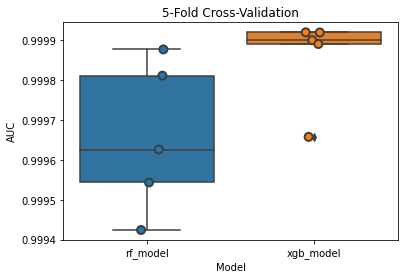

In [198]:
sns.boxplot(x = 'Model', y = 'AUC', data = df_forests).set_title('5-Fold Cross-Validation')
sns.stripplot(x = 'Model', y = 'AUC', data = df_forests, size = 8, jitter = True, edgecolor = 'gray', linewidth = 2)

#### I chose the XGB model because it outperformed the others.

In [475]:
xgb_pipeline = Pipeline(
    [('preprocessor', preprocessor), 
     ('select', SelectPercentile(percentile = 33)),
     ('model', models['xgb_model'])]
)

In [52]:
xgb_pipeline2 = Pipeline([('preprocessor', preprocessor), ('select', SelectPercentile(percentile = 33)), ('model', models['xgb_model'])])

## 5. Threshold Selection

#### Split into train and validation data

In [477]:
X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size = .2, random_state = 2)

In [478]:
y_train.shape

(100776,)

In [479]:
y_train_benign = y_train.map(lambda x: 0.0 if x == 'benign' else 1.0)
y_val_benign = y_val.map(lambda x: 0.0 if x == 'benign' else 1.0)

In [480]:
y_test_benign = y_test.map(lambda x: 0.0 if x == 'benign' else 1.0)

In [481]:
xgb_pipeline.fit(X_train, y_train_benign)

XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

In [58]:
print(len(xgb_pipeline.steps[2][1].feature_importances_), 'total features')

39 total features


### Find the optimal threshold
#### I plot the ROC curve and determine the threshold where the true positive rate is 1 (TP/TP+FP). The goal is to maximize recall and minimize the number of attacks that pass through the detection system while not sacrificing the integrity of the algorithm by flagging too many false positives. 

In [59]:
target_probabilities = xgb_pipeline.predict_proba(X_val)[:,1]
false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_val_benign, target_probabilities)

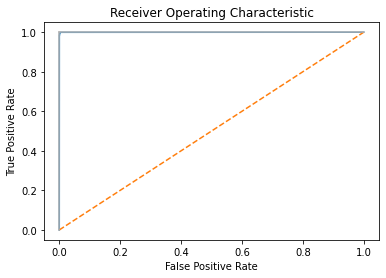

In [60]:
# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0.0, 1.0], ls="--")
plt.plot([0.0, 0.0], [1.0, 0.0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

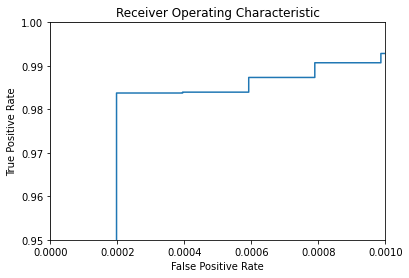

In [61]:
# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0.0, 1.0], ls="--")
plt.plot([0.0, 0.0], [1.0, 0.0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.axis([0.0, 0.001, 0.95, 1.0])
plt.show()

In [62]:
optimal_threshold = 0
for i in range(len(threshold)):
    if true_positive_rate[i] == 1.0:
        optimal_threshold = threshold[i]
        print(optimal_threshold)
        break

0.0050058886


In [63]:
y_val_preds_new = [1.0 if x >= optimal_threshold else 0.0 for x in target_probabilities]

In [64]:
print(accuracy_score(y_val_benign, y_val_preds_new))
print(classification_report(y_val_benign, y_val_preds_new))
print(confusion_matrix(y_val_benign, y_val_preds_new))

0.9846391998094784
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      5066
         1.0       0.98      1.00      0.99     20128

    accuracy                           0.98     25194
   macro avg       0.99      0.96      0.98     25194
weighted avg       0.98      0.98      0.98     25194

[[ 4679   387]
 [    0 20128]]


#### With this set threshold, the recall in the validation set is maximized, keeping the number of false negatives (ie attacks that weren't detected) to 0.

In [65]:
test_probabilities = xgb_pipeline.predict_proba(X_test)[:,1]
y_test_preds_new = [1.0 if x >= optimal_threshold else 0.0 for x in test_probabilities]

### Evaluation post-threshold shift

In [66]:
print("Baseline Classification Report")
y_preds_base = ([0]*9625) + ([1]*3208) + ([0]*261) + ([1]*9450)
y_test_base = ([0]*9625) + ([0]*3208) + ([1]*261) + ([1]*9450)
print(accuracy_score(y_test_base, y_preds_base))
print(classification_report(y_test_base, y_preds_base))
print(confusion_matrix(y_test_base, y_preds_base))

Baseline Classification Report
0.8461231369765791
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     12833
           1       0.75      0.97      0.84      9711

    accuracy                           0.85     22544
   macro avg       0.86      0.86      0.85     22544
weighted avg       0.88      0.85      0.85     22544

[[ 8502  1209]
 [ 1093 11740]]


In [67]:
print(accuracy_score(y_test_benign, y_test_preds_new))
print(classification_report(y_test_benign, y_test_preds_new))
print(confusion_matrix(y_test_benign, y_test_preds_new))

0.897888573456352
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88      9711
         1.0       0.91      0.91      0.91     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

[[ 8502  1209]
 [ 1093 11740]]


In [68]:
false_pos = 1209
false_neg = 1093
num_samples = 22544
print('True positive %: {}'.format(1-(false_pos/num_samples)))
print('True negative %: {}'.format(1-(false_neg/num_samples)))

True positive %: 0.9463715400993613
True negative %: 0.9515170333569908


In [464]:
sns.set(rc={"figure.dpi":100, "savefig.dpi": 100})
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [469]:
def plot_full_report(y_actual, y_preds, yticklabels = 'auto', support = True, name = 'default.png'):
    my_dict = classification_report(y_actual, y_preds, output_dict = True)
    df_multi = pd.DataFrame(my_dict)
    fig, axs = plt.subplots(ncols = 2, figsize=(16,5))
    cm = confusion_matrix(y_actual, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['benign', 'malicious'])
    plt.grid(False)
#     fig.set_visible(False)
#     fig.set_figheight(2)
    if support == True:
        heat = sns.heatmap(df_multi.drop(columns = ['macro avg', 'weighted avg', 'accuracy']).T, annot = True, cmap = 'RdYlGn', yticklabels = yticklabels, vmin = 0, vmax = 1, fmt = '.2f', ax = axs[0])
#         plt.show()
    else:
        heat = sns.heatmap(df_multi.iloc[:-1, :].drop(columns = ['macro avg', 'weighted avg', 'accuracy']).T, annot = True, cmap = 'RdYlGn', yticklabels = yticklabels, vmin = 0, vmax = 1, fmt = '.2f',ax = axs[0] )
        
#         plt.show()
    disp.plot(ax = axs[1])
    plt.show()
    fig.savefig(name, format = 'png', dpi = 300)

In [470]:
def print_confusion(y_actual, y_preds):
    cm = confusion_matrix(y_actual, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['benign', 'malicious'])
    disp.plot()
    plt.grid(False)
    plt.show()

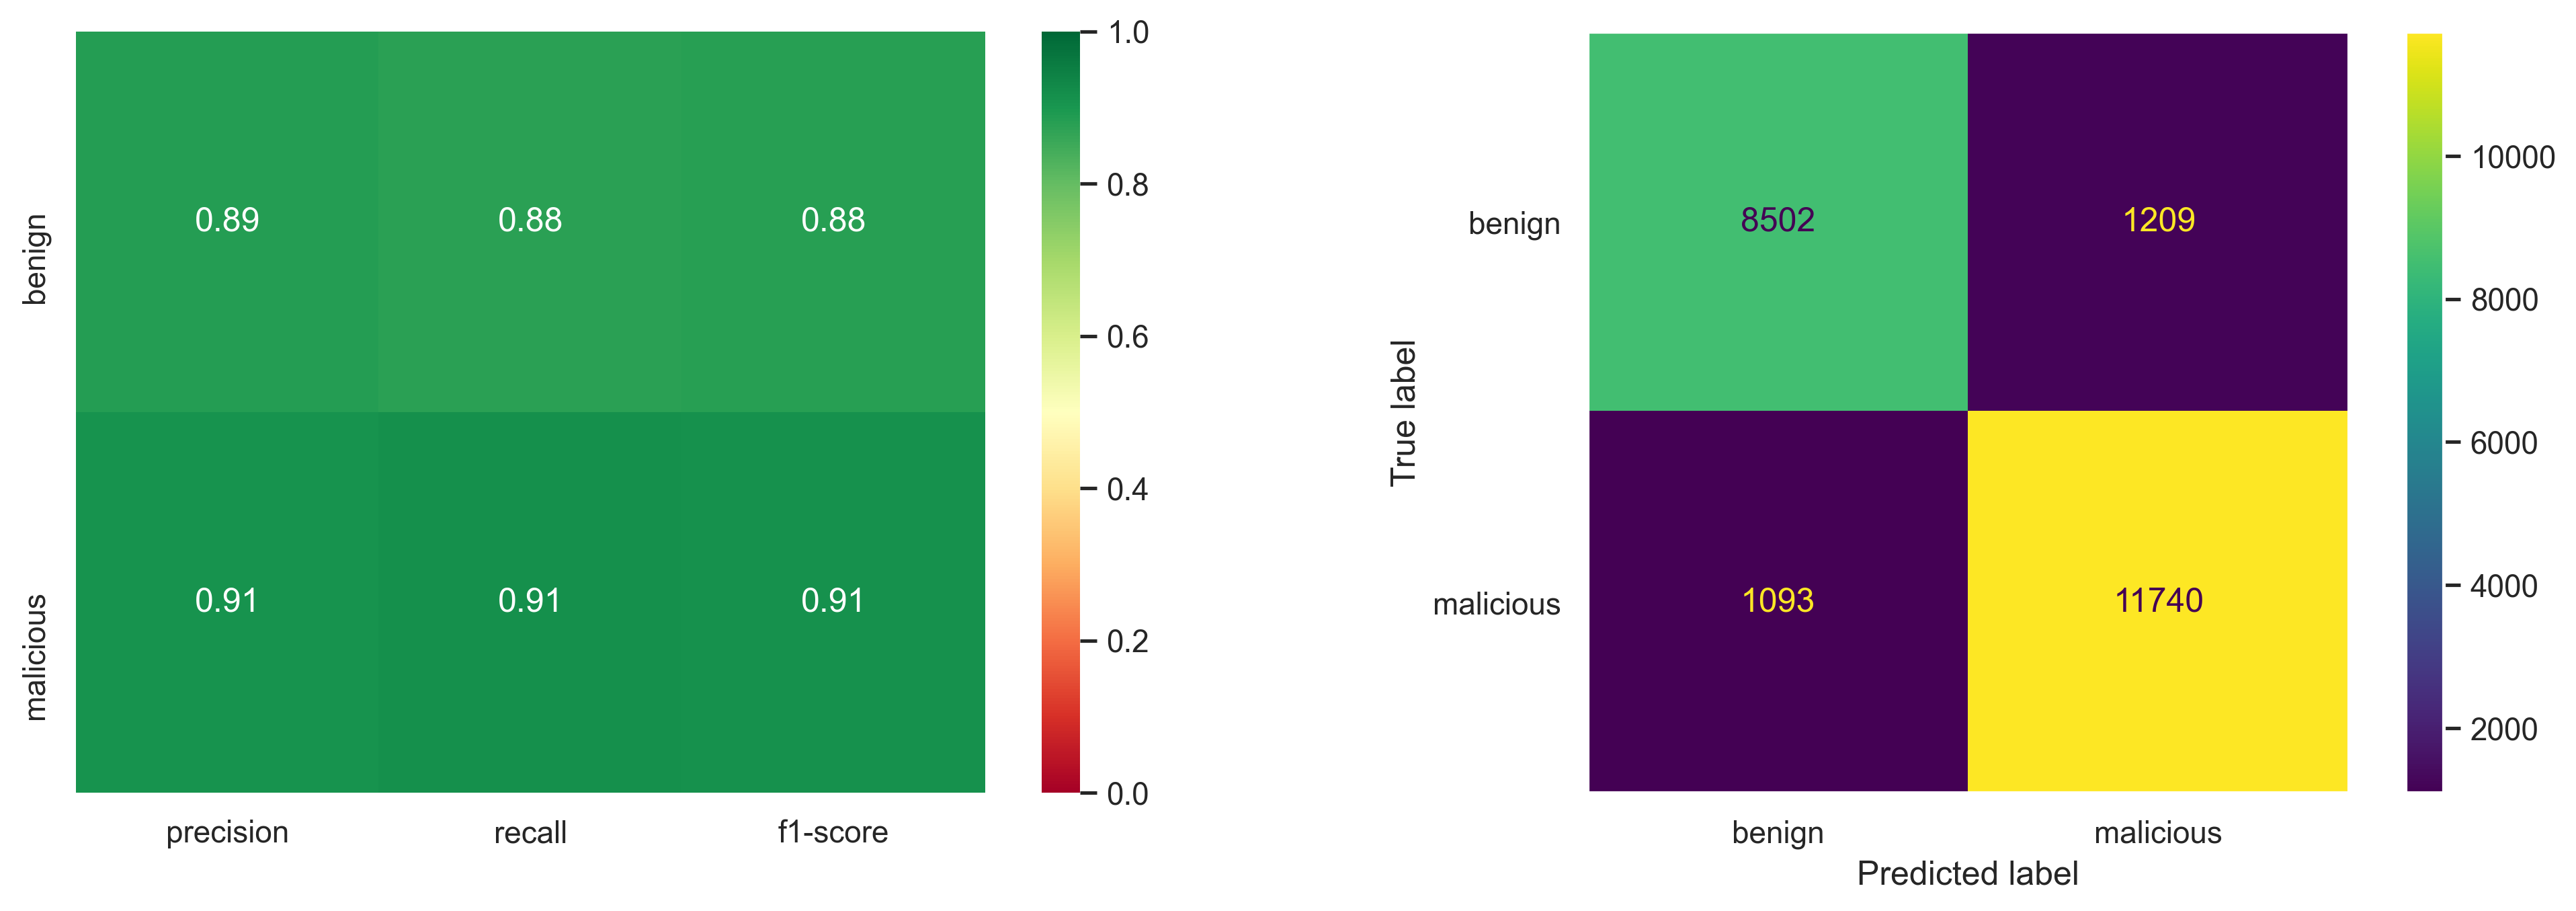

In [451]:
plot_full_report(y_test_benign, y_test_preds_new, ['benign', 'malicious'], support = False, name = '/Users/shaeferdrew/Downloads/thresh_full_rep.png')

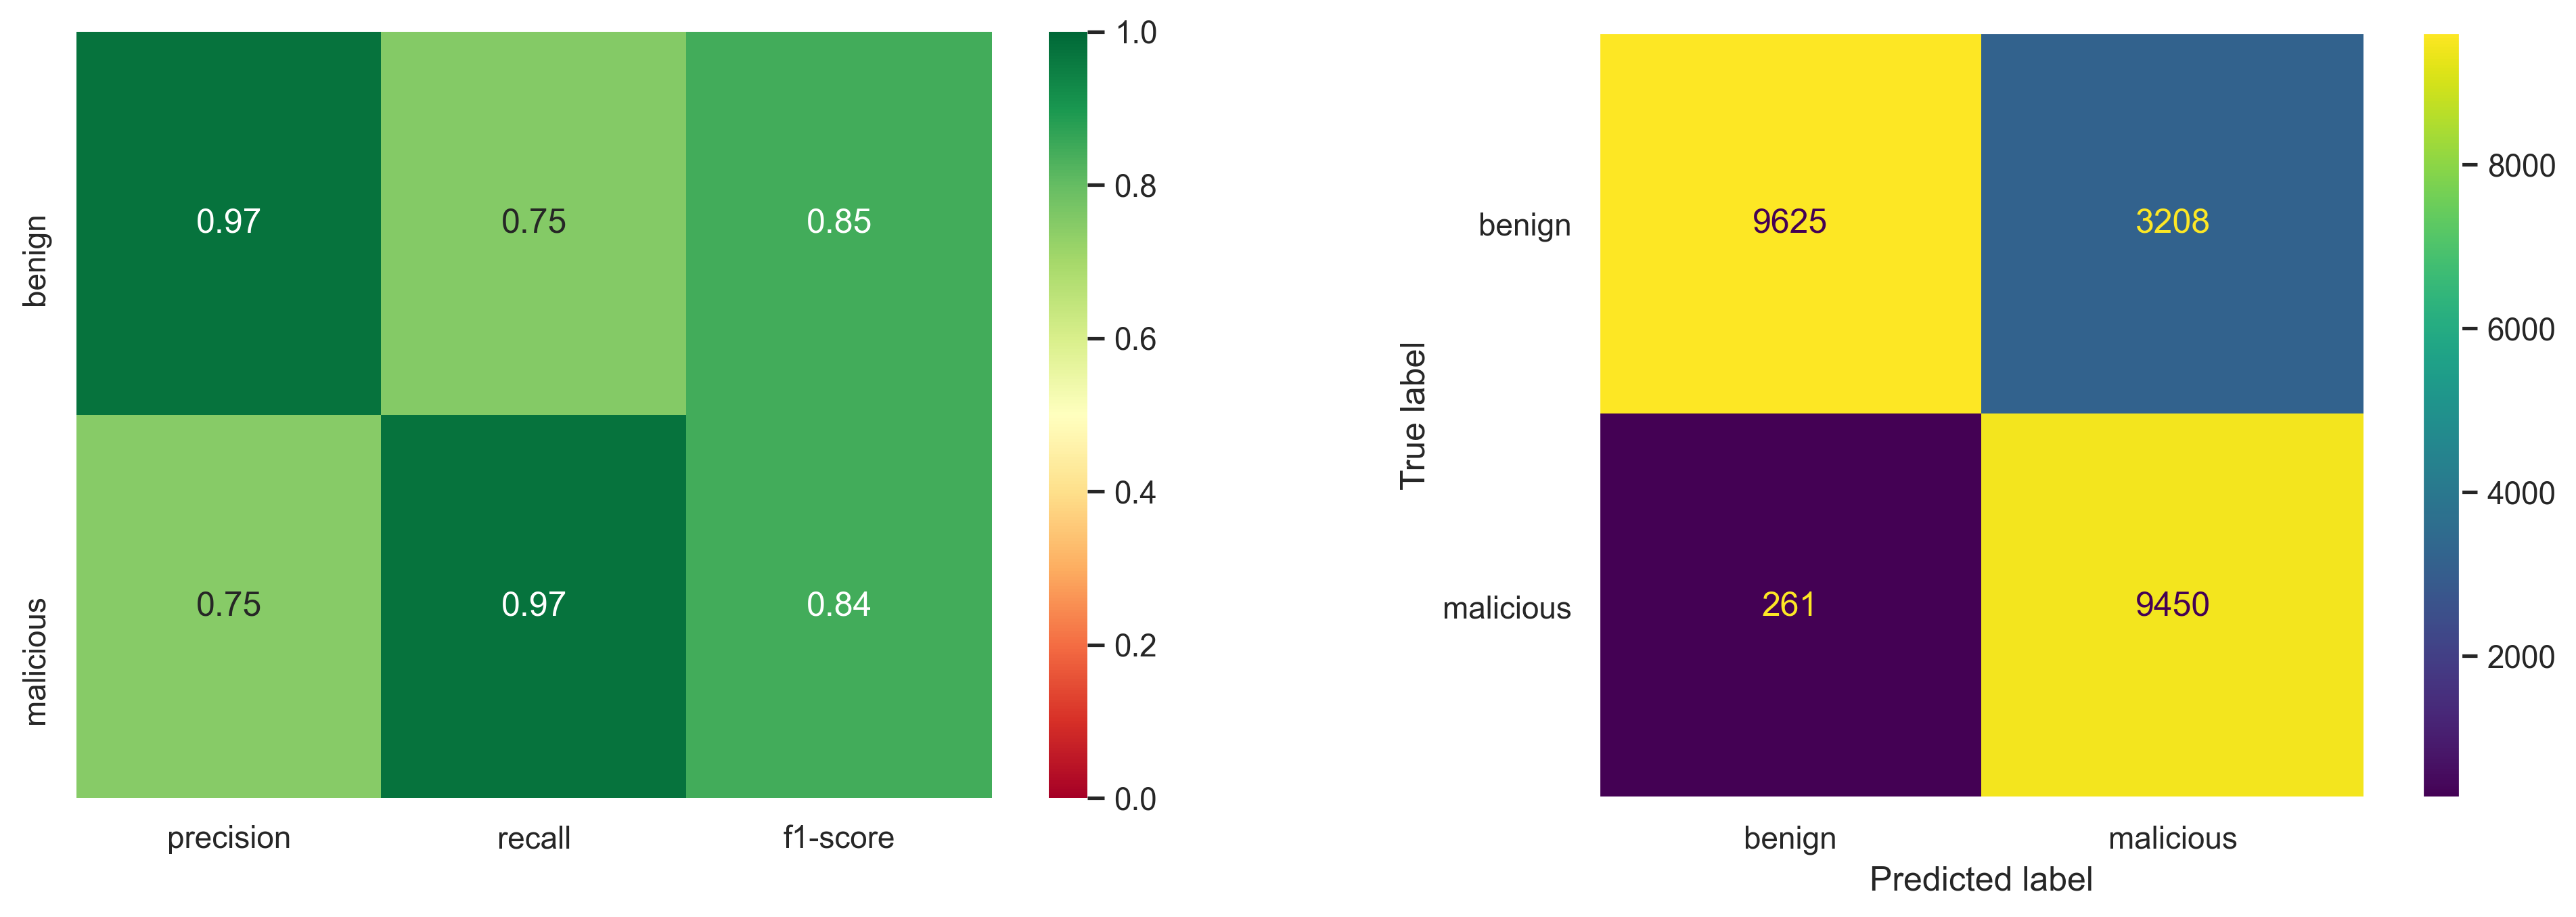

In [421]:
plot_full_report(y_test_base, y_preds_base, ['benign', 'malicious'], support = False)

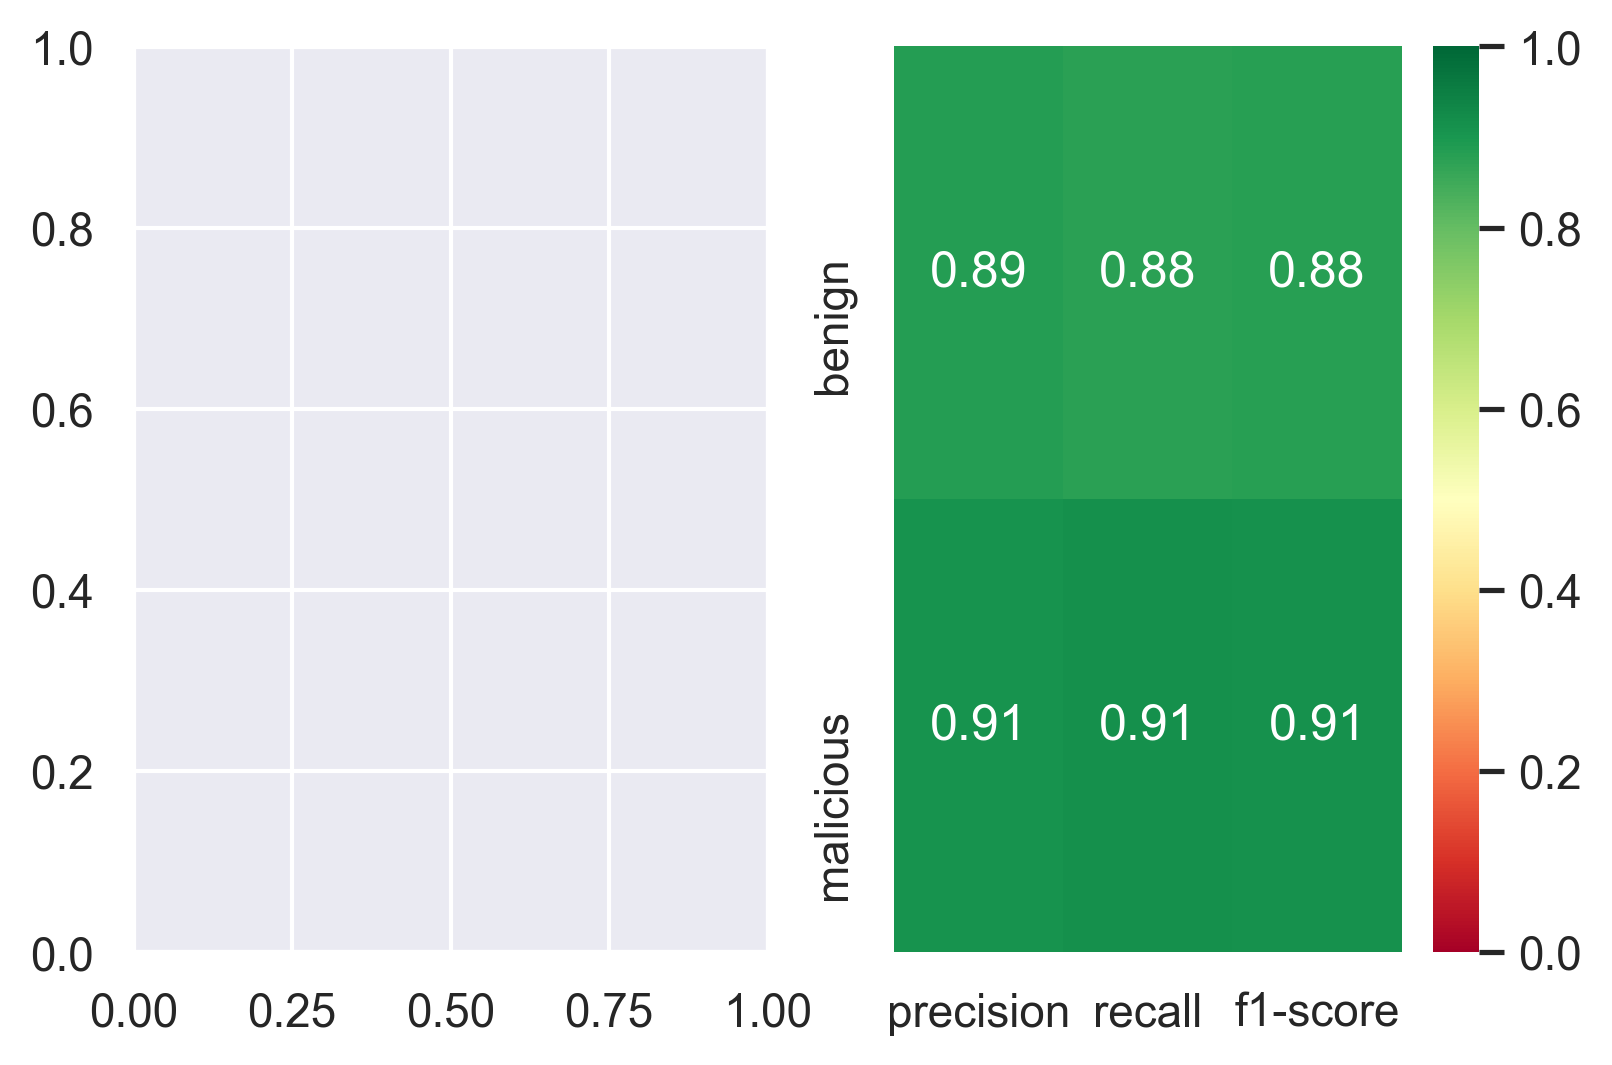

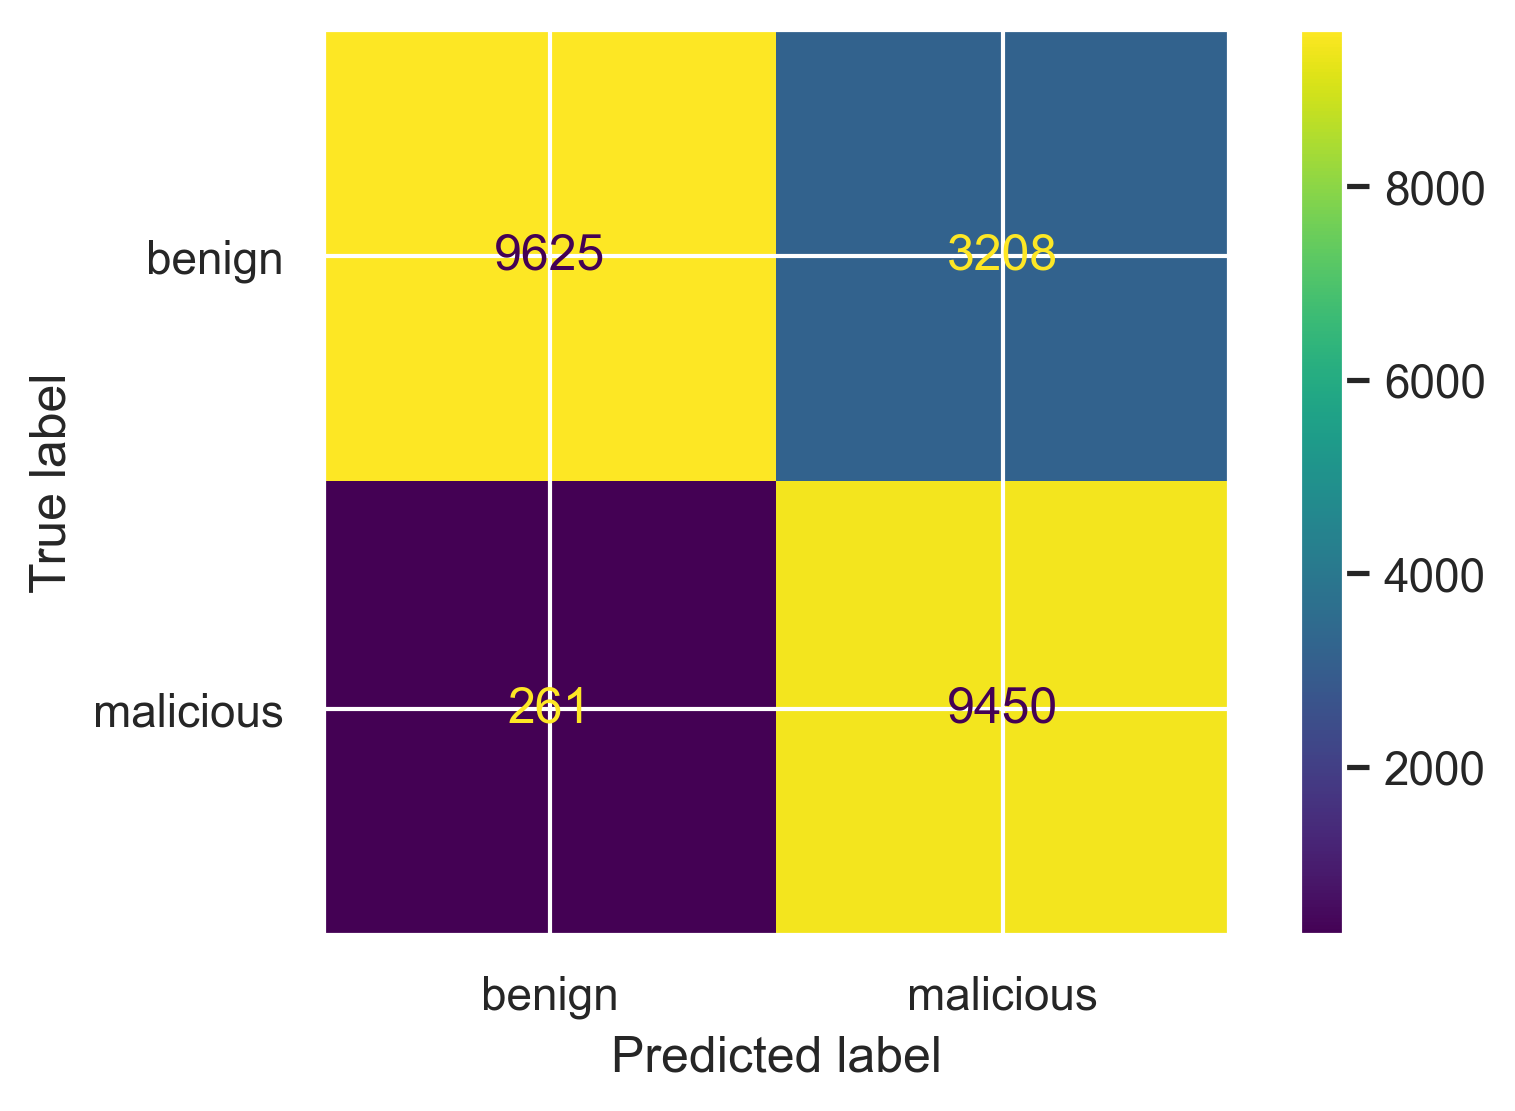

In [410]:
fig, axs = plt.subplots(1,2)
plot_class_report(y_test_benign, y_test_preds_new, ['benign', 'malicious'], support = False)
print_confusion(y_test_base, y_preds_base)
plt.show()

In [ ]:
test_probabilities = xgb_pipeline.predict_proba(X_test)[:,1]
y_test_preds_new = [1.0 if x >= optimal_threshold else 0.0 for x in test_probabilities]

In [471]:
no_thres = xgb_pipeline.predict(X_test)

In [474]:
no_thres

array(['dos', 'dos', 'benign', ..., 'dos', 'benign', 'benign'],
      dtype=object)

In [472]:
plot_class_report(y_test_benign, no_thres, ['benign', 'malicious'], support = False)

ValueError: Mix of label input types (string and number)

In [473]:
print_confusion(y_test_benign, no_thres)

ValueError: Mix of label input types (string and number)

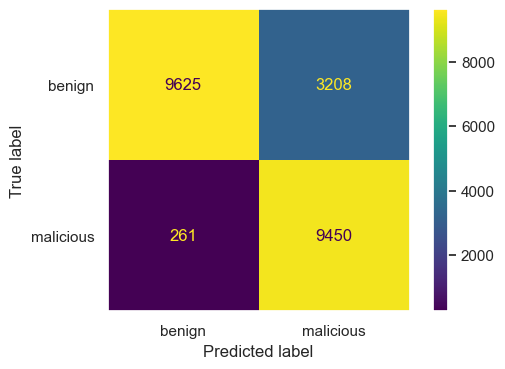

In [466]:
print_confusion(y_test_base, y_preds_base)

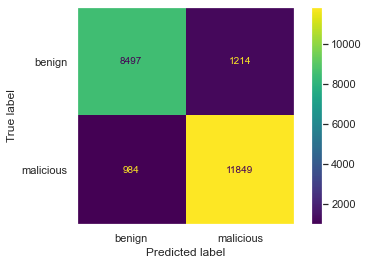

In [518]:
print_confusion(y_test_benign, y_test_preds_combined)


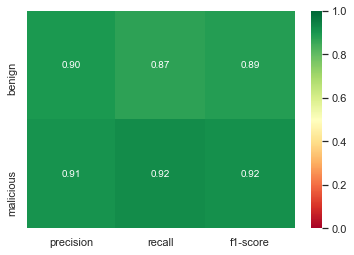

In [519]:
plot_class_report(y_test_benign, y_test_preds_combined, ['benign', 'malicious'], support = False)

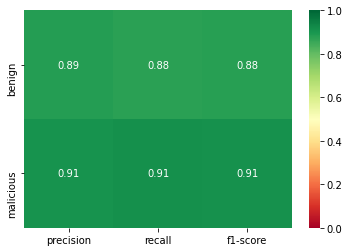

In [199]:
plot_class_report(y_test_benign, y_test_preds_new, ['benign', 'malicious'], support = False)

#### My approach has an improved accuracy score 5.2% higher than the baseline and an improved true positive percentage by 8.9% , with the sacrifice of a decreased true negative percentage by 3.7%. With a precision of 91%, if my algorithm flags an attack, there is a 91% chance it is an actual attack, as opposed to the 75% chance that an attack flagged by the baseline is an actual attack. 

#### With my model, there are 832 more unflagged attacks, but 1999 fewer cases that were labeled as an attack but weren't. A topic that may spawn further research from my end is measuring the impact of attacks vs impact of the security team focusing on false positives. Just speculating, one may expect an undetected attack to have a much greater adverse impact than a false positive, but if a security analyst is spending all their time mitigating false positives, they may be too late to mitigate an actual attack. For the sake of not vearing too far off topic, let's just assume that a false negative is 2x as bad as a false positive to an organization. So the loss of 1999 false positives outweighs the gain of 832 false negatives. (1999 - (832*2) = 335).

#### I wanted to further explore ways I could improve the recall while maintaining the precision I had. Thinking about cyber attack patterns, many attackers will create new malware that is either slightly different from a previous version, very different, or a completely new zero day exploit. So how can a machine learning algorithm label an instance that is slightly/very different or even not at all similar to any of the training data its seen? Clustering can help with all of the above, to group similar occurances as well as detect outliers.

## 6. Unsupervised Modeling - Clustering

In [69]:
X_train_, X_val_, y_train_orig, y_val_orig = train_test_split(X, y, test_size = .2, random_state = 2)

In [70]:
X_train_ = X_train_[continuous_cols]
X_train_ = preprocessor.fit_transform(X_train_)
X_val_ = X_val_[continuous_cols]
X_val_ = preprocessor.transform(X_val_)
X_test_ = X_test[continuous_cols]
X_test_ = preprocessor.transform(X_test_)

In [71]:
y_train_ = y_train_orig.map(lambda x: 0.0 if x == 'benign' else 1.0)
y_val_ = y_val_orig.map(lambda x: 0.0 if x == 'benign' else 1.0)
y_test_ = y_test.map(lambda x: 0.0 if x == 'benign' else 1.0)

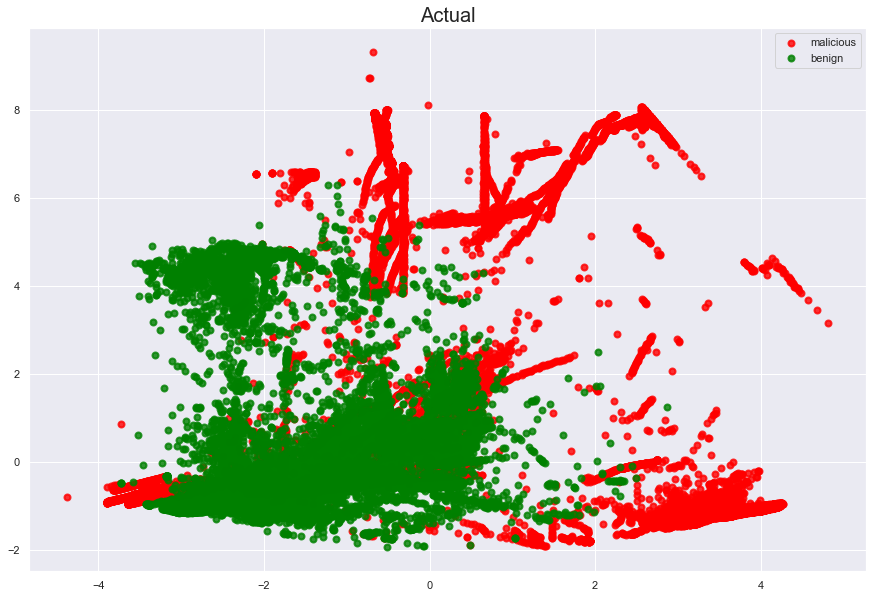

In [515]:
# Actual
# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(X_train_)

plt.figure(figsize=(15,10))
colors = ['red', 'green']

for color, cat in zip(colors, [1.0, 0.0]):
    if cat == 1.0:
        lab = 'malicious'
    else:
        lab = 'benign'
    plt.scatter(train_x_pca_cont[y_train_==cat, 0], train_x_pca_cont[y_train_==cat, 1],
                color=color, alpha=.8, lw=2, label=lab)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Actual', fontsize = 20)
plt.show()

In [487]:
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(X_train_)

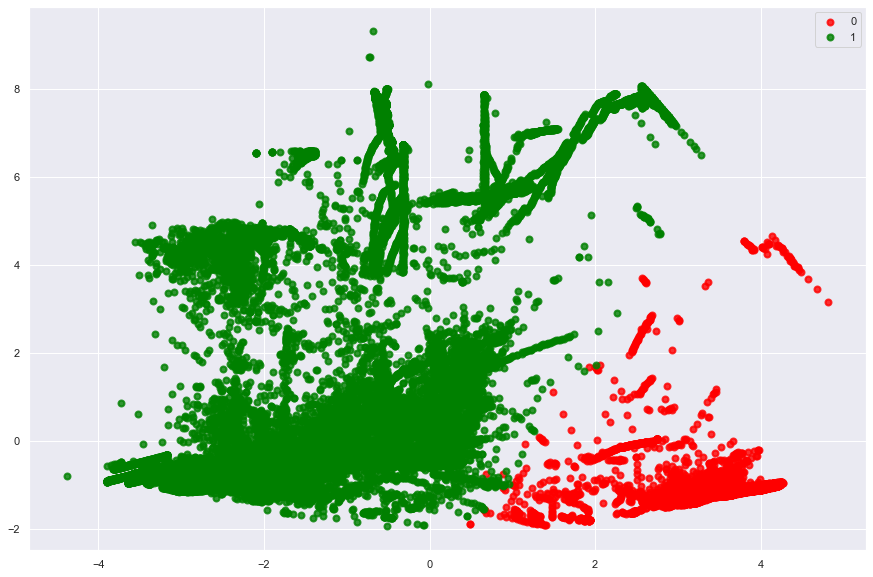

In [488]:
# Predicted
# Fit the training data to a k-means clustering estimator model
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=2).fit(X_train_)

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# Plot in 2d with train_x_pca_cont
plt.figure(figsize=(15,10))
colors = ['red', 'green']

for color, cat in zip(colors[:num_clusters], range(num_clusters)):
    plt.scatter(train_x_pca_cont[kmeans_y==cat, 0],
                train_x_pca_cont[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

#### As you can see, using 2 clusters for benign and malicious doesn't work very well. So I experimented with different sizes and techniques for determining whether each cluster should be labeled malicious or benign.

#### The techniques used to label malicious or benign include outlier detection (unseen attacks in the training set may look like outliers in the holdout set) and cases where the significant majority of the cluster is labeled as malicious. These techniques focus on maximizing malicous recall since that's how I'm aiming to suppliment the xgboost model.

#### To sum it up:
- If the % of malicious traffic within a cluster is greater than 95%, all instances in the cluster are labeled as malicious.
- If the cluster size relative to the total population is less than 0.1%, all instances in the cluster are labeled as malicious.

In [492]:
def get_mal_k(num_clusters, X_train, percentage = .95, proportion = .001):
    '''
    Returns malicious cluster numbers as well as a dataframe for labeling each cluster
    num_clusters: number of clusters to perform k-means on
    X_train: Training data
    percentage: Percentage of which malicious labels must be above for the cluster to be labeled malicious.
    proportion: The size of the cluster
    '''
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X_train)
    kmeans_train_y = kmeans.labels_
    df_crosstab = pd.crosstab(kmeans_train_y, y_train_, rownames = ['cluster'])
    df_crosstab['mal_perc'] = df_crosstab[1.0] / (df_crosstab[1.0] + df_crosstab[0.0])
    df_crosstab['outlier'] = (df_crosstab[1.0] + df_crosstab[0.0]) <= (len(X_train) * proportion)
    df_crosstab2 = df_crosstab.copy()
    def label_mal(df):
        if (df['mal_perc'] >= .95) or (df['outlier'] == True):
            return True
        else:
            return False
    df_crosstab2['label_malicious'] = df_crosstab2.apply(label_mal, axis = 1)
    df_crosstab = df_crosstab[(df_crosstab['mal_perc'] >= percentage) | (df_crosstab['outlier'] == True)]
    return list(df_crosstab.index), df_crosstab2

### Optimize parameters
- After optimizing for the F1 Score to balance precision and recall, the parameters chosen were a cluster size of 27, malicious label percentage of 95%, and cluster sample proportion of 0.1%

In [510]:
pca = PCA(n_components=31)
train_x_pca_cont = pca.fit_transform(X_train_)

In [511]:
mal_ks, df_crosstab = get_mal_k(27, train_x_pca_cont, .95, .001)

### Visualize

In [496]:
df_crosstab.rename(columns = {0.0: 'benign', 1.0: 'malicious'})

attack_category,benign,malicious,mal_perc,outlier,label_malicious
cluster,,,,,
0,5168,495,0.087410,False,False
1,53,27511,0.998077,False,True
2,15207,260,0.016810,False,False
3,93,6719,0.986348,False,True
4,1,0,0.000000,True,True
5,4062,121,0.028927,False,False
6,0,715,1.000000,False,True
7,1,2105,0.999525,False,True
8,196,3073,0.940043,False,False


In [512]:
colors = []
n = 27
for i in range(n):
    if i in mal_ks:
        colors.append('red')
    else:
        colors.append('green')

#### Predicted

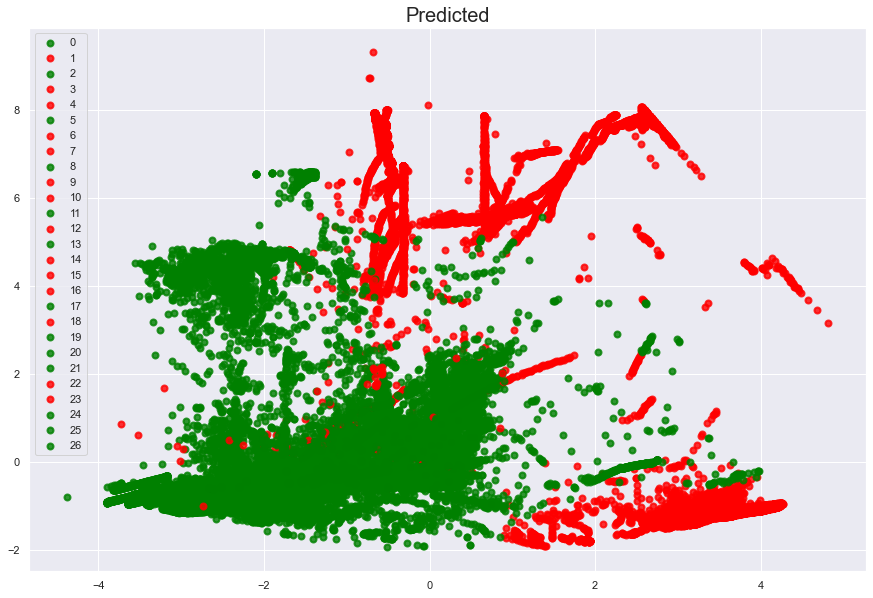

In [513]:

# Fit the training data to a k-means clustering estimator model
num_clusters = 27
kmeans = KMeans(n_clusters=num_clusters, random_state=2).fit(train_x_pca_cont)

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# Plot in 2d with train_x_pca_cont
plt.figure(figsize=(15,10))

pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(X_train_)
for color, cat in zip(colors[:num_clusters], range(num_clusters)):
    plt.scatter(train_x_pca_cont[kmeans_y==cat, 0],
                train_x_pca_cont[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Predicted', fontsize = 20)
plt.show()

In [489]:
from random import randint

colors = []
n = 27

for i in range(n):
    colors.append('#%06X' % randint(0, 0xFFFFFF))


In [490]:
colors

['#CAF2DB',
 '#EC07C1',
 '#0D6FAE',
 '#0B99DC',
 '#7285E8',
 '#EF6A89',
 '#07CAF8',
 '#390EA0',
 '#B890C3',
 '#CF2EAD',
 '#D25097',
 '#19FB8A',
 '#282D68',
 '#266AD2',
 '#51A75C',
 '#6B5D61',
 '#C06247',
 '#5D4CF1',
 '#6DEB71',
 '#6307DF',
 '#E74839',
 '#1849C5',
 '#39EF54',
 '#D7FB3D',
 '#47E3B8',
 '#5891BD',
 '#6D8A3E']

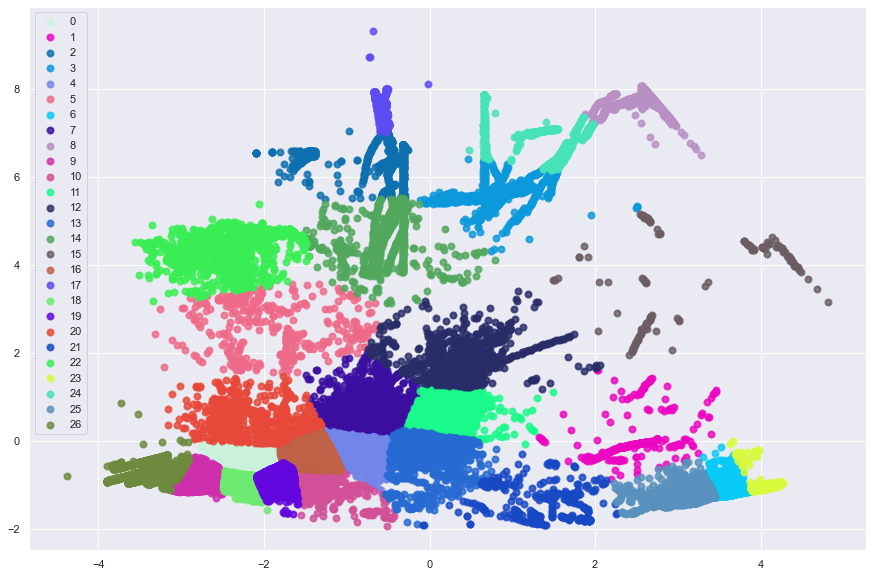

In [491]:

# Fit the training data to a k-means clustering estimator model
num_clusters = 27
kmeans = KMeans(n_clusters=num_clusters, random_state=2).fit(train_x_pca_cont)

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# Plot in 2d with train_x_pca_cont
plt.figure(figsize=(15,10))

pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(X_train_)
for color, cat in zip(colors[:num_clusters], range(num_clusters)):
    plt.scatter(train_x_pca_cont[kmeans_y==cat, 0],
                train_x_pca_cont[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

#### Actual

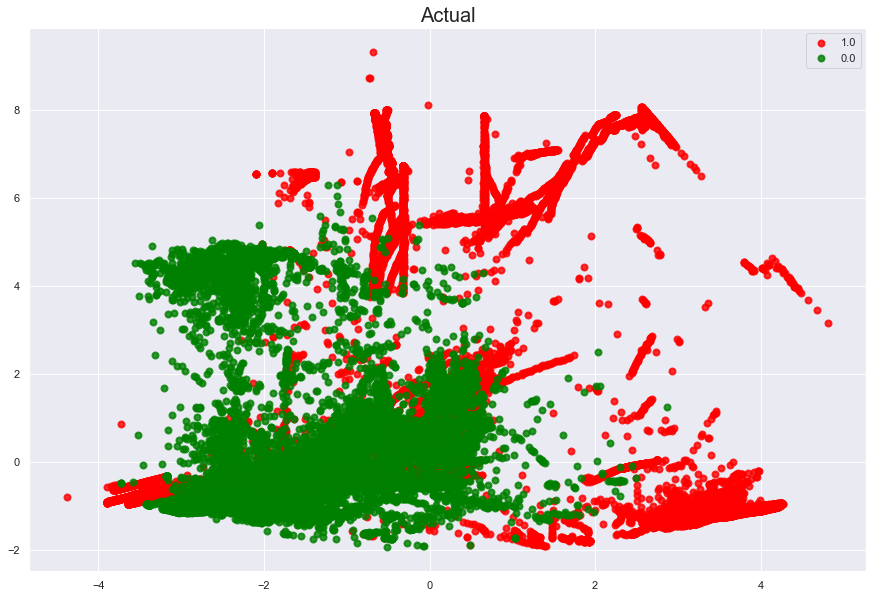

In [514]:
# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(X_train_)

plt.figure(figsize=(15,10))
colors = ['red', 'green']

for color, cat in zip(colors, [1.0, 0.0]):
    plt.scatter(train_x_pca_cont[y_train_==cat, 0], train_x_pca_cont[y_train_==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Actual', fontsize = 20)
plt.show()

## 7. Combine Supervised and Unsupervised Models

In [82]:
pca = PCA(n_components=31)
train_x_pca_cont = pca.fit_transform(X_train_)
test_x_pca_cont = pca.transform(X_test_)


In [83]:
kmeans = KMeans(n_clusters=27, random_state=2)
kmeans.fit(train_x_pca_cont)
mal_ks = get_mal_k(27, train_x_pca_cont, .95, .001)[0]

kmeans_train_labels = kmeans.labels_
kmeans_test_labels = kmeans.predict(test_x_pca_cont)
kmeans_test_y = [1.0 if y in mal_ks else 0.0 for y in kmeans_test_labels]


y_test_preds_combined = [max(kmeans_test_y[i], y_test_preds_new[i]) for i in range(len(kmeans_test_y))]

## 8. Evaluation

In [84]:
print("Baseline Classification Report")
y_preds_base = ([0]*9625) + ([1]*3208) + ([0]*261) + ([1]*9450)
y_test_base = ([0]*9625) + ([0]*3208) + ([1]*261) + ([1]*9450)
print(accuracy_score(y_test_base, y_preds_base))
print(classification_report(y_test_base, y_preds_base))
print(confusion_matrix(y_test_base, y_preds_base))

Baseline Classification Report
0.8461231369765791
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     12833
           1       0.75      0.97      0.84      9711

    accuracy                           0.85     22544
   macro avg       0.86      0.86      0.85     22544
weighted avg       0.88      0.85      0.85     22544

[[9625 3208]
 [ 261 9450]]


In [85]:
false_pos = 3208
false_neg = 261
num_samples = 22544
print('True positive %: {}'.format(1-(false_pos/num_samples)))
print('True negative %: {}'.format(1-(false_neg/num_samples)))

True positive %: 0.8577004968062456
True negative %: 0.9884226401703335


In [86]:
print("Classification Approach")
print(accuracy_score(y_test_benign, y_test_preds_new))
print(classification_report(y_test_benign, y_test_preds_new))
print(confusion_matrix(y_test_benign, y_test_preds_new))

Classification Approach
0.897888573456352
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88      9711
         1.0       0.91      0.91      0.91     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

[[ 8502  1209]
 [ 1093 11740]]


In [87]:
false_pos = 1209
false_neg = 1093
num_samples = 22544
print('True positive %: {}'.format(1-(false_pos/num_samples)))
print('True negative %: {}'.format(1-(false_neg/num_samples)))

True positive %: 0.9463715400993613
True negative %: 0.9515170333569908


In [88]:
print('Classification & Clustering Combined Approach')
print(accuracy_score(y_test_benign, y_test_preds_combined))
print(classification_report(y_test_benign, y_test_preds_combined))
print(confusion_matrix(y_test_benign, y_test_preds_combined))

Classification & Clustering Combined Approach
0.9025017743080199
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      9711
         1.0       0.91      0.92      0.92     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

[[ 8497  1214]
 [  984 11849]]


In [89]:
false_pos = 1214
false_neg = 984
num_samples = 22544
print('True positive %: {}'.format(1-(false_pos/num_samples)))
print('True negative %: {}'.format(1-(false_neg/num_samples)))

True positive %: 0.9461497515968772
True negative %: 0.9563520227111426


#### Complementing classification with clustering went as planned, where it improved the recall for malicious traffic while maintaining precision.  In combining classification with clustering, the algorithm found 109 new malicious attacks at the small price of only mislabeling 5; thereby, increased classifier performance without degrading its integrity.

## 9. Explainability

In [90]:
xgb_pipeline.fit(X_train, y_train_benign)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'num_compromised',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                               

In [91]:
X_train_new = xgb_pipeline.steps[0][1].transform(X_train)
X_train_new = xgb_pipeline.steps[1][1].transform(X_train_new)

X_test_new = xgb_pipeline.steps[0][1].transform(X_test)
X_test_new = xgb_pipeline.steps[1][1].transform(X_test_new)

In [92]:
xgb_pipeline2.fit(X_train, y_train)

[08:35:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'num_compromised',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                               

In [93]:
X_train_new2 = xgb_pipeline2.steps[0][1].transform(X_train)
X_train_new2 = xgb_pipeline2.steps[1][1].transform(X_train_new2)
X_test_new2 = xgb_pipeline2.steps[0][1].transform(X_test)
X_test_new2 = xgb_pipeline2.steps[1][1].transform(X_test_new2)

In [94]:
def label_mal(df):
    if (df['mal_perc'] >= .95) or (df['outlier'] == True):
        return True
    else:
        return False
df_crosstab = pd.crosstab(kmeans_train_labels, y_train_)

df_crosstab['mal_perc'] = df_crosstab[1.0] / (df_crosstab[1.0] + df_crosstab[0.0])
outliers = (df_crosstab[1.0] + df_crosstab[0.0]) <= (len(X_train_) * .001)
df_crosstab['outlier'] = outliers
malicious_labels = df_crosstab.apply(label_mal, axis = 1)
df_crosstab['label_malicious'] = malicious_labels
df_crosstab = pd.crosstab(kmeans_train_labels, y_train_orig)
df_crosstab['label_malicious'] = malicious_labels
df_crosstab['outlier'] = outliers
df_crosstab['max'] = df_crosstab.iloc[:,:4].idxmax(axis = 1)

In [95]:

def explain_instance(i, df_crosstab):
    mal_dict = {0.0: 'benign', 1.0: 'malicious'}
    def label_mal(df):
        if (df['mal_perc'] >= .95) or (df['outlier'] == True):
            return True
        else:
            return False
    if kmeans_test_y[i] > y_test_preds_new[i]:
        print('cluster:', kmeans_test_labels[i])
        print('Actual Value:', y_test_benign[i])
        print('Predicted value:', y_test_preds_combined[i])
        
        
        df_cluster_weights = pd.DataFrame(columns = continuous_cols, data = kmeans.cluster_centers_)
        cg = sns.clustermap(df_cluster_weights, vmin = -3, vmax = 3)
        row_order = cg.dendrogram_row.reordered_ind
        plot = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        cg.ax_heatmap.add_patch(Rectangle((0, row_order.index(kmeans_test_labels[i])), 31, 1, fill=False, edgecolor='yellow', lw=4, clip_on=False))
        
        cg.ax_heatmap.tick_params(length=0)
        plt.show()
        
        
        if df_crosstab.loc[kmeans_test_labels[i]]['outlier'] == True:
            reason = 'outlier'
        else:
            reason = df_crosstab.loc[kmeans_test_labels[i]]['max']
        
        feature_tup = sorted(dict(df_cluster_weights.iloc[kmeans_test_labels[i]]).items(), key = lambda x: abs(x[1]), reverse = True)
        names = [x[0] for x in feature_tup][:10]
        vals = [X_test.iloc[i][x[0]] for x in feature_tup][:10]
        df_features = pd.DataFrame({'Feature': names, 'Original Values': vals})
        display(df_features)
        print('This connection is labeled as', str(mal_dict[y_test_preds_combined[i]]) + ', part of which may be explained by its', feature_tup[0][0], 'of', X_test.iloc[i][feature_tup[0][0]], ',', feature_tup[1][0], 'of', X_test.iloc[i][feature_tup[1][0]], ',and', feature_tup[2][0], 'of', X_test.iloc[i][feature_tup[2][0]])
        print('This attack is most likely classified as', reason + '.')
    else:
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train_new ,class_names=[0.0, 1.0], feature_names = list(X_train.columns[xgb_pipeline.steps[1][1].get_support()]),
                                                   discretize_continuous = False, mode = 'classification')
        exp = explainer.explain_instance(X_test_new[i], xgb_pipeline.steps[2][1].predict_proba, num_features=10)
        exp.as_pyplot_figure()
        print('Predicted Proba:', xgb_pipeline.steps[2][1].predict_proba(X_test_new[[i]])[:, 1][0])
        print('Optimal Threshold:', optimal_threshold)

        print('Actual Value:', y_test_benign[i])
        print('Predicted value:', y_test_preds_combined[i])
        feature_tup = exp.as_list()
        names = [x[0] for x in feature_tup]
        vals = [X_test.iloc[i][x[0]] for x in feature_tup]
        df_features = pd.DataFrame({'Feature': names, 'Original Values': vals})
        display(df_features)
        
        print('This connection is labeled as', str(mal_dict[y_test_preds_combined[i]]) + ', part of which may be explained by its', feature_tup[0][0], 'of', X_test.iloc[i][feature_tup[0][0]], ',', feature_tup[1][0], 'of', X_test.iloc[i][feature_tup[1][0]], ',and', feature_tup[2][0], 'of', X_test.iloc[i][feature_tup[2][0]])
        if y_test_preds_combined[i] == 1.0:
            if xgb_pipeline2.steps[2][1].predict(X_test_new2[[i]])[0] != 'benign':
                print('This attack is most likely classified as', xgb_pipeline2.steps[2][1].predict(X_test_new2[[i]])[0] + '.')

Predicted Proba: 0.9988638
Optimal Threshold: 0.0050058886
Actual Value: 1.0
Predicted value: 1.0


,Feature,Original Values
0,num_root,0.00
1,dst_host_count,255.00
2,dst_host_srv_diff_host_rate,0.00
3,diff_srv_rate,0.06
4,flag_SF,0.00
5,dst_host_diff_srv_rate,0.06
6,service_private,1.00
7,is_guest_login,0.00
8,count,136.00
9,flag_REJ,1.00


This connection is labeled as malicious, part of which may be explained by its num_root of 0.0 , dst_host_count of 255.0 ,and dst_host_srv_diff_host_rate of 0.0
This attack is most likely classified as dos.


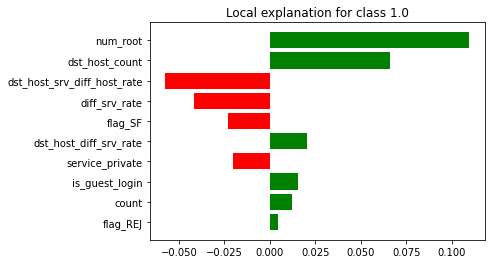

In [96]:
explain_instance(1, df_crosstab)

cluster: 7
Actual Value: 1.0
Predicted value: 1.0


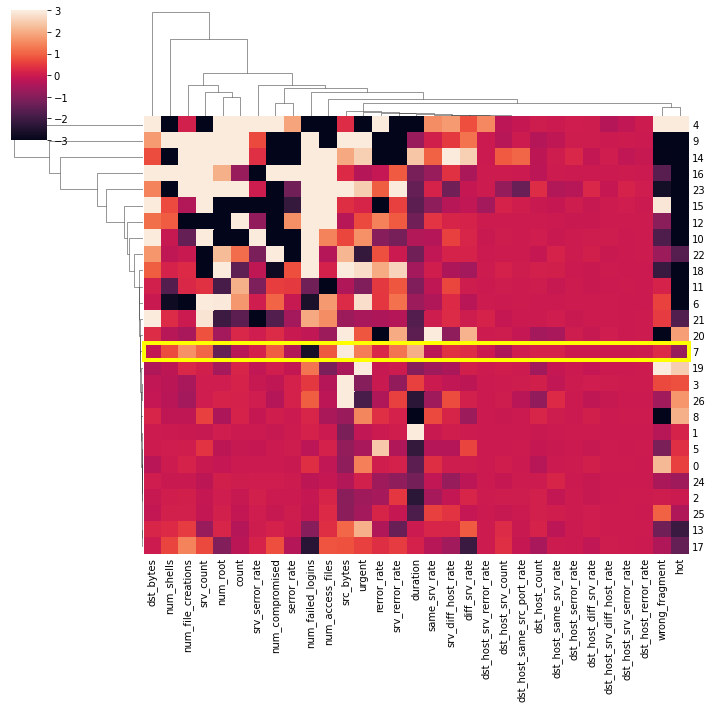

,Feature,Original Values
0,src_bytes,0.0
1,num_failed_logins,0.0
2,duration,0.0
3,num_file_creations,0.0
4,num_root,0.0
5,urgent,0.0
6,srv_rerror_rate,1.0
7,srv_count,7.0
8,num_compromised,0.0
9,num_access_files,0.0


This connection is labeled as malicious, part of which may be explained by its src_bytes of 0.0 , num_failed_logins of 0.0 ,and duration of 0.0
This attack is most likely classified as probe.


In [97]:
explain_instance(87, df_crosstab)

## 10. Dashboard

Check out my [Network Intrusion Detection Engine Dashboard](https://shaeferd-network-traffic-prediction-detection-dashboard-wo3p21.streamlitapp.com/) to better understand why the model made certain predictions and the actionable insights that can be learned from the data. 

## 11. Conclusion

Intrusion Detection Modeling Approach:

overleaf.com

## 12. Next Steps 

### Output for dashboard

In [98]:
# xgb_pipelines
pickle.dump(xgb_pipeline, open("models/xgb_pipeline.sav", 'wb'))
pickle.dump(xgb_pipeline2, open("models/xgb_pipeline2.sav", 'wb'))

In [99]:
# kmeans
pickle.dump(kmeans, open("models/kmeans.sav", 'wb'))

In [100]:
# label lists
df_labels = pd.DataFrame({'kmeans_test_y': kmeans_test_y, 'y_test_preds_new': y_test_preds_new,
                         'y_test_benign': y_test_benign, 'y_test_preds_combined': y_test_preds_combined,
                         'test_probabilities': test_probabilities})
df_labels.to_csv('data/labels.csv', index = False)

In [101]:
# dataframes
X_test.to_csv('data/X_test.csv', index = False)
X_train.to_csv('data/X_train.csv', index = False)

In [102]:
# arrays
def write_array(file_name, content):
    np.savetxt(file_name, content, fmt="%2.3f", delimiter=",")
write_array('data/X_train_new2.txt', X_train_new2)
write_array('data/X_test_new2.txt', X_test_new2)
write_array('data/X_train_new.txt', X_train_new)
write_array('data/X_test_new.txt', X_test_new)
# write_array('data/continuous_cols.txt', continuous_cols)

In [103]:
df_cont = pd.DataFrame({"continuous_cols": continuous_cols})
df_cont.to_csv('data/continuous_cols.csv', index = False)

In [104]:
df_test_labels = pd.DataFrame({'y_train_benign': y_train_benign, 'y_train': y_train})
df_test_labels.to_csv('data/df_test_labels.csv', index = False)

In [105]:
df_kmeans = pd.DataFrame({'kmeans_test_labels': kmeans_test_labels})
df_kmeans.to_csv('data/kmeans_test_labels.csv', index = False)

In [106]:
df_crosstab.to_csv('data/df_crosstab.csv', index = False)